In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import Demand
import Solar
import Price
import Date
import Forecast

In [2]:
'''
NEW smart in a perfect world
'''

'\nNEW smart in a perfect world\n'

In [3]:
def predictedcharge(bigdata, daywanted):
    
    eff = 0.9
    predicted_charge = 0
    
    for n in range(0,24):
             
        if bigdata['Net Demand'][n] <= 0:
            predicted_charge = predicted_charge - bigdata['Net Demand'][n]*eff
    
    return predicted_charge

In [4]:
def chargeneeded(bigdata):

    eff = 0.9
    chargeneeded = 0
    median = np.median(bigdata['Grid Buy Price'])
    batterycharge = 0
    

    for n in range(0,24):
            
        if bigdata['Grid Buy Price'][n] >= median*1.5:
            chargeneeded = chargeneeded + bigdata['Net Demand'][n]/(eff)


    return chargeneeded


In [5]:
## method to run the SMART system ##
## if its predicted

def run_SMART(bigdata, daywanted, starting_soc):
    
    batteryoutput = np.zeros(24)
    soc = np.ones(24)*0
    capacity = 1120
    power = 415
    eff = 0.9
    leftover = 0
    
    median = np.median(bigdata['Grid Buy Price'])
    required_battery_charge = chargeneeded(bigdata)
    predicted_battery_charge = predictedcharge(bigdata, daywanted)
    
#     print(required_battery_charge, predicted_battery_charge)
    
    for n in range(0,24):
        
        if n == 0:
            soc_temp = starting_soc[daywanted-1]
        else:
            soc_temp = soc[n-1]

        ## the smart design ##
        ## the smart design ##
        ## the smart design ##

        
        if required_battery_charge > predicted_battery_charge: 
            if n == 4:
                batteryoutput[n] = max(-power, -(1/eff)*(required_battery_charge - predicted_battery_charge), -(1/eff)*(capacity - soc_temp))
                soc[n] = soc_temp - batteryoutput[n]*eff
                leftover = required_battery_charge - predicted_battery_charge - batteryoutput[n]
                continue
            if n == 5 and leftover > 0:
                batteryoutput[n] = max(-power, -(1/eff)*leftover, -(1/eff)*(capacity - soc_temp))
                soc[n] = soc_temp - batteryoutput[n]*eff
                leftover = leftover - batteryoutput[n]
                continue
            if n == 6 and leftover > 0:
                batteryoutput[n] = max(-power, -(1/eff)*leftover, -(1/eff)*(capacity - soc_temp))
                soc[n] = soc_temp - batteryoutput[n]*eff
                leftover = leftover - batteryoutput[n]
                continue
                
        if n == 0:
            use = True
        if n == 14:
            use = False
        if bigdata['Grid Buy Price'][n] >= median*1.5:
            use = True
            

        ## the smart design ##
        ## the smart design ##
        ## the smart design ##

        if bigdata['Net Demand'][n] > 0:   #using the battery
            batteryoutput[n] = min(bigdata['Net Demand'][n], soc_temp*eff, power)
            soc[n] = soc_temp - batteryoutput[n]*(1/eff)
            if use == False:
                soc[n] = soc[n-1]
                batteryoutput[n] = 0

        elif bigdata['Net Demand'][n] < 0:     # charge the battery
            batteryoutput[n] = max(bigdata['Net Demand'][n], -(1/eff)*(capacity - soc_temp), -power)
            soc[n] = soc_temp - batteryoutput[n]*(eff)

        elif bigdata['Net Demand'][n] == 0:      # do nothing
            soc[n] = soc_temp

        
    ## adds the battery output to total demand and adds to bigdata ##

    bigdata['Net Demand - SMART'] = bigdata['Net Demand']-batteryoutput
    bigdata['Running Cost - SMART'] = bigdata['Net Demand - SMART']*bigdata['Grid Buy Price']
    bigdata['Running Cost - SMART'] = bigdata['Running Cost - SMART'].clip(lower=0)
    bigdata['Running Profit - SMART'] = -bigdata['Net Demand - SMART']*bigdata['Grid Sell Price']
    bigdata['Running Profit - SMART'] = bigdata['Running Profit - SMART'].clip(lower=0)
    bigdata['soc - SMART'] = soc
    bigdata['battery output - SMART'] = batteryoutput
    
    ## adds the end day soc into the global vector to use for the next day ##
    starting_soc[daywanted] = soc[23]
    ## returns the new bigdata ##
    
    return bigdata


In [6]:
## initialises the daily cost vectors ##
SMART_cost = np.zeros(365)
SMART_profit = np.zeros(365)
_import_ = np.zeros(24*365)
_export_ = np.zeros(24*365)
solar_prediction = pd.read_csv('Data/solarprediction.csv')
# starting_soc = np.zeros(365)
starting_soc = np.zeros(366)


for n in range(0, 365):

    ## loads in the data ##

    daywanted = n+1
    datewanted = Date.getdatewanted(daywanted, 2014)
    totaldemand = Demand.gettotaldemand(daywanted)
    solarsupply = Solar.getsolarsupply(daywanted)
    buyprice = Price.getvariablebuyprice(daywanted)
    sellprice = Price.getvariablesellprice(daywanted)
    bigdata =pd.concat([totaldemand, solarsupply, buyprice, sellprice], axis=1)
    bigdata['Net Demand'] = bigdata['Total Demand (kWh)']-bigdata['Total Supply (kWh)']
    bigdata['Running Cost'] = bigdata['Grid Buy Price']*bigdata['Net Demand']
    bigdata['Running Cost'] = bigdata['Running Cost'].clip(lower=0)
    bigdata['Running Profit'] = -bigdata['Grid Sell Price']*bigdata['Net Demand']
    bigdata['Running Profit'] = bigdata['Running Profit'].clip(lower=0)

    ## runs the battery for that day ##
    
    bigdata = run_SMART(bigdata, daywanted, starting_soc)

    ## adds the day into the year vector ##

 
    SMART_cost[n] = bigdata['Running Cost - SMART'].sum()
    SMART_profit[n] = bigdata['Running Profit - SMART'].sum()
    
#     _import_[n] = bigdata['Net Demand - SMART'].clip(lower=0).sum()
#     temp = bigdata['Net Demand - SMART']*(-1)
#     _export_[n] = temp.clip(lower=0).sum()
    
    ## adds the day into the year vector ##

    for q in range(24):
    
        if bigdata['Net Demand - SMART'][q] < 0:
            _export_[n*24+q] = bigdata['Net Demand - SMART'][q]*-1
            
        if bigdata['Net Demand - SMART'][q] > 0:
            _import_[n*24+q] = bigdata['Net Demand - SMART'][q]


In [7]:
SMART_cost.sum()

9637.823231599908

In [8]:
SMART_profit.sum()

74933.53755291573

In [9]:
SMART_profit.sum()-SMART_cost.sum()

65295.71432131583

In [10]:
_import_.sum()

117455.13182564362

In [11]:
_export_.sum()

1087650.1910817185

In [12]:
_export_.sum()-_import_.sum()

970195.059256075

Text(0.5, 1.0, 'Export')

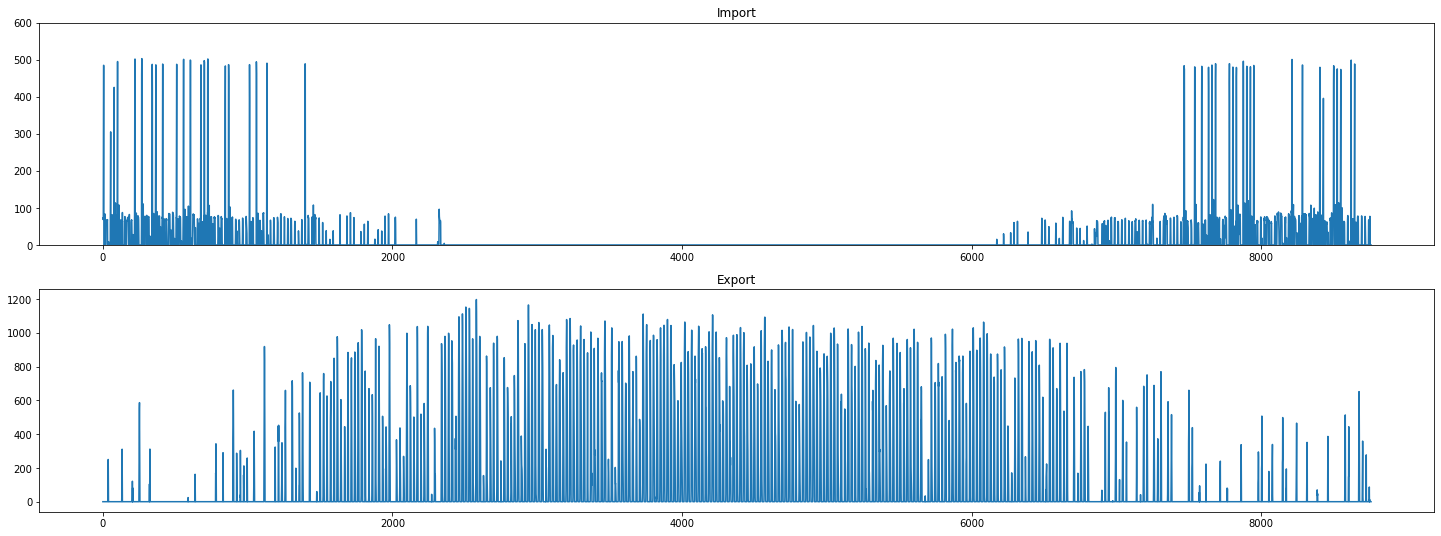

In [13]:
fig, ax = plt.subplots(2, figsize=[25,9])

ax[0].plot(_import_)
ax[0].set_title('Import')
ax[0].set_ylim(0, 600)
ax[1].plot(_export_)
ax[1].set_title('Export')

In [14]:
importing = pd.DataFrame(_import_)
exporting = pd.DataFrame(_export_)
exporting.to_csv('Export_vector.csv')
importing.to_csv('Import_vector.csv')